In [20]:
# === Preloaded Libraries ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.inspection import permutation_importance

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestClassifier
from sklearn.svm import SVR, SVC
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import precision_recall_curve

from sklearn.metrics import (
    mean_squared_error, mean_absolute_error, r2_score,
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, confusion_matrix, ConfusionMatrixDisplay,
    roc_curve
)

from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# PreStep 1. Impute-Transform-Normalize the data

In [2]:
# Step 1: Load the data
a = pd.read_csv('1320_combined_phe_noITM_gen_Imt.csv')  # Main dataset
b = pd.read_csv('diagnostics_DW.csv')                   # Processing instructions

# Create a dictionary from b for faster lookup
processing_rules = {}
for _, row in b.iterrows():
    feature = row['Feature']
    processing_rules[feature] = {
        'imputation': row['Imputation_suggestion'],
        'transformation': row['Transformation_suggestion'],
        'normalization': row['Normalization_suggestion'],
        'drop': row['Dropping_suggestion']
    }

# Step 2-3: Process each feature according to diagnostics_DW.csv
for feature in a.columns:
    if feature in processing_rules:
        rules = processing_rules[feature]
        
        # Skip if marked for dropping
        if rules['drop'] == 'Y':
            a.drop(feature, axis=1, inplace=True)
            continue
            
        # Imputation
        if rules['imputation'] == 'mean':
            a[feature].fillna(a[feature].mean(), inplace=True)
        elif rules['imputation'] == 'median':
            a[feature].fillna(a[feature].median(), inplace=True)
        elif rules['imputation'] == 'none':
            pass  # No imputation
            
        # Transformation
        if rules['transformation'] == 'log1p':
            a[feature] = np.log1p(a[feature])
        elif rules['transformation'] == 'boxcox':
            # Box-Cox requires positive values
            if (a[feature] <= 0).any():
                a[feature] = a[feature] + 1 - a[feature].min()
            a[feature], _ = stats.boxcox(a[feature])
            
        # Normalization
        if rules['normalization'] == 'zscore':
            scaler = StandardScaler()
            a[feature] = scaler.fit_transform(a[[feature]]).flatten()
        elif rules['normalization'] == 'minmax':
            scaler = MinMaxScaler()
            a[feature] = scaler.fit_transform(a[[feature]]).flatten()

# Step 4: Check NA values
print("NA values after processing:")
print(a.isna().sum())

# Step 5: Save results
a.to_csv('1320_combined_phe_Imt_gen_Imt.csv', index=False)

print("Processing complete. Results saved to 1320_combined_phe_Imt_gen_Imt.csv")

/var/folders/n5/h18rv7ns13l1ty5kvvj2yd440000gn/T/ipykernel_3450/2928660019.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  a = pd.read_csv('1320_combined_phe_noITM_gen_Imt.csv')  # Main dataset
/var/folders/n5/h18rv7ns13l1ty5kvvj2yd440000gn/T/ipykernel_3450/2928660019.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  a[feature].fillna(a[feature].mean(), inplace=True)
/var/folders/n5/h18rv7ns13l1ty5kvvj2yd440000gn/T/ipykernel_3450/2928660019.py:30: FutureWarning: A 

NA values after processing:
phe_ID        0
Plot#         0
Entry#        0
IRGC ID       0
Genotype      0
             ..
6_17959093    0
6_17970505    0
6_17973167    0
6_17979534    0
6_17979772    0
Length: 16431, dtype: int64
Processing complete. Results saved to 1320_combined_phe_Imt_gen_Imt.csv


In [4]:
# === Step 0: Load Data ===
df = pd.read_csv("1320_combined_phe_Imt_gen_Imt.csv")
drop_cols = ['Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', 'Subpopulation', '3k-population']
df.drop(columns=drop_cols, inplace=True)

for col in ['Genotype', 'Treatment']:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

/var/folders/n5/h18rv7ns13l1ty5kvvj2yd440000gn/T/ipykernel_3450/963827531.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("1320_combined_phe_Imt_gen_Imt.csv")


In [5]:
# === Step 2: 85/15 Stratified Split ===
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.15, random_state=42)
for train_idx, test_idx in splitter.split(df, df["Flowering Success"]):
    df_train = df.iloc[train_idx].reset_index(drop=True)
    df_extval = df.iloc[test_idx].reset_index(drop=True)

In [36]:
# ===== Step 2-1:Save to CSV
df_train.to_csv('1320_combined_phe_Imt_gen_Imt_train.csv', index=False)
df_extval.to_csv('1320_combined_phe_Imt_gen_Imt_extval.csv.csv', index=False)

In [42]:
# === Step 3-4: Train & Evaluate Regression Models ===
regression_target = "FilledGrain#"
regression_features = df_train.drop(columns=["phe_ID", regression_target])
y_reg = df_train[regression_target]
X_reg_scaled = StandardScaler().fit_transform(regression_features)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_reg_scaled, y_reg, test_size=0.2, random_state=123)

reg_models = {
    "LinearRegression": LinearRegression(),
    "Ridge": Ridge(),
    "Lasso": Lasso(),
    "ElasticNet": ElasticNet(),
    "RandomForest": RandomForestRegressor(random_state=42),
    "SVR": SVR(),
    "XGBoost": XGBRegressor(random_state=42),
    "NeuralNet": MLPRegressor(max_iter=1000, random_state=42),
    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42),
    "HistGradientBoosting": HistGradientBoostingRegressor(random_state=42)
}

reg_results = {"Model": [], "RMSE": [], "R2": []}
for name, model in reg_models.items():
    model.fit(X_train_r, y_train_r)
    preds = model.predict(X_test_r)
    reg_results["Model"].append(name)
    reg_results["RMSE"].append(mean_squared_error(y_test_r, preds, squared=False))
    reg_results["R2"].append(r2_score(y_test_r, preds))

reg_df = pd.DataFrame(reg_results)
reg_df["Rank"] = reg_df["R2"].rank(ascending=False).astype(int)
print("Regression Performance:\n", reg_df)

neg_r2_models = reg_df[reg_df["R2"] < 0]["Model"].tolist()
if neg_r2_models:
    print("\nModels with negative R²:", neg_r2_models)

Regression Performance:
                    Model      RMSE        R2  Rank
0       LinearRegression  0.363768  0.841698     6
1                  Ridge  0.365339  0.840328     7
2                  Lasso  0.915350 -0.002330     9
3             ElasticNet  0.865504  0.103862     8
4           RandomForest  0.173842  0.963847     4
5                    SVR  0.954070 -0.088924    10
6                XGBoost  0.150586  0.972873     2
7              NeuralNet  1.042643 -0.300492    11
8           DecisionTree  0.204444  0.949998     5
9       GradientBoosting  0.129208  0.980028     1
10  HistGradientBoosting  0.154782  0.971340     3

Models with negative R²: ['Lasso', 'SVR', 'NeuralNet']


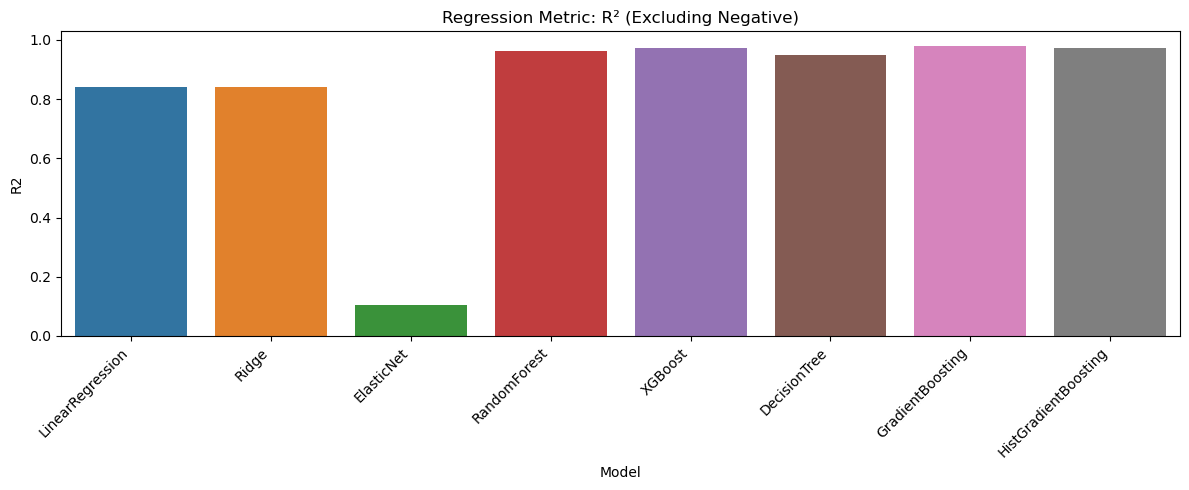

In [43]:
# === Step 3-5: Visualize Regression Performance (Filtered) ===
filtered_df = reg_df[reg_df["R2"] >= 0]
plt.figure(figsize=(12, 5))
sns.barplot(x="Model", y="R2", data=filtered_df)
plt.xticks(rotation=45, ha="right")
plt.title("Regression Metric: R² (Excluding Negative)")
plt.tight_layout()
plt.savefig("Step3-5_Regression_Metrics_R2_filtered.png", dpi=300)
plt.show()

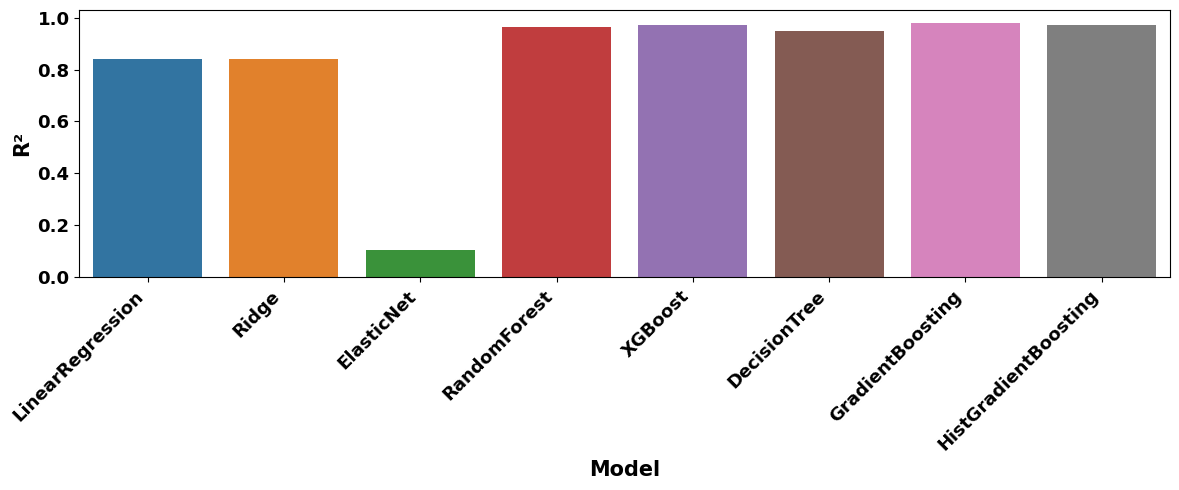

In [72]:
# === Step 3-5: Visualize Regression Performance (Filtered)(advanced) ===
filtered_df = reg_df[reg_df["R2"] >= 0]
plt.figure(figsize=(12, 5))
sns.barplot(x="Model", y="R2", data=filtered_df)
plt.xticks(rotation=45, ha="right", fontsize=13, fontweight='bold')
plt.yticks(fontsize=13, fontweight='bold')
plt.xlabel("Model", fontsize=15, fontweight='bold')
plt.ylabel("R²", fontsize=15, fontweight='bold')
# Remove the title
# plt.title("Regression Metric: R² (Excluding Negative)")  # Commented out or deleted
plt.tight_layout()
plt.savefig("Step3-5_Regression_Metrics_R2_filtered_advanced.png", dpi=300)
plt.show()

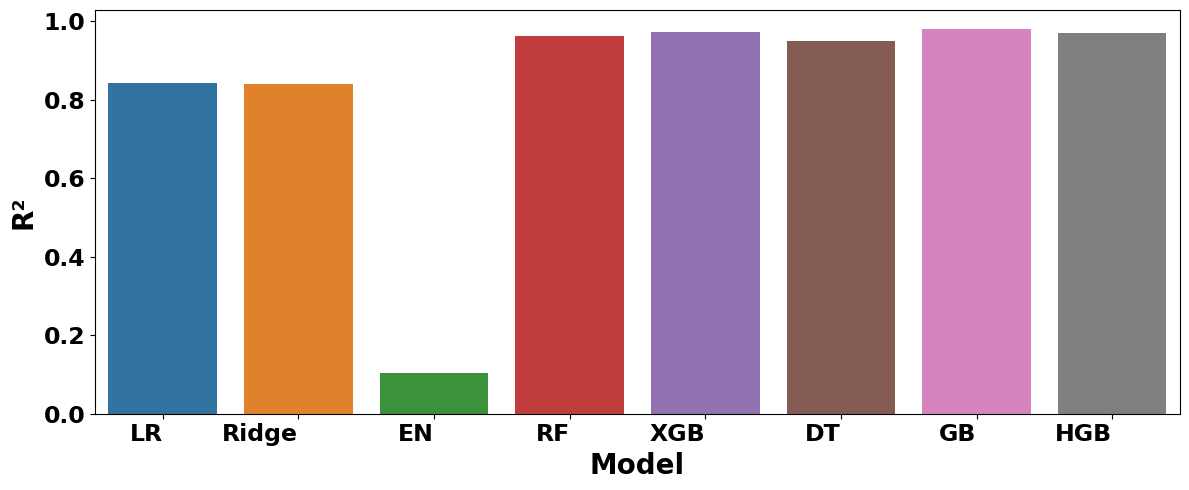

In [76]:
# === Step 3-5: Visualize Regression Performance (Filtered) ===
filtered_df = reg_df[reg_df["R2"] >= 0]

# Define abbreviation mapping
label_map = {
    "LinearRegression": "LR",
    "Ridge": "Ridge",
    "ElasticNet": "EN",
    "RandomForest": "RF",
    "XGBoost": "XGB",
    "DecisionTree": "DT",
    "GradientBoosting": "GB",
    "HistGradientBoosting": "HGB"
}

# Ensure consistent ordering
model_order = filtered_df["Model"].tolist()
abbrev_labels = [label_map.get(model, model) for model in model_order]

plt.figure(figsize=(12, 5))
ax = sns.barplot(x="Model", y="R2", data=filtered_df)

# Apply abbreviations to x-axis labels
ax.set_xticklabels(abbrev_labels, rotation=0, ha="right", fontsize=17, fontweight="bold")
plt.yticks(fontsize=17, fontweight="bold")
plt.xlabel("Model", fontsize=20, fontweight="bold")
plt.ylabel("R²", fontsize=20, fontweight="bold")

# Optional: Remove the title
# plt.title("Regression Metric: R² (Excluding Negative)")  # omitted per request

plt.tight_layout()
plt.savefig("Step3-5_Regression_Metrics_R2_filtered_good_labels.png", dpi=300)
plt.show()

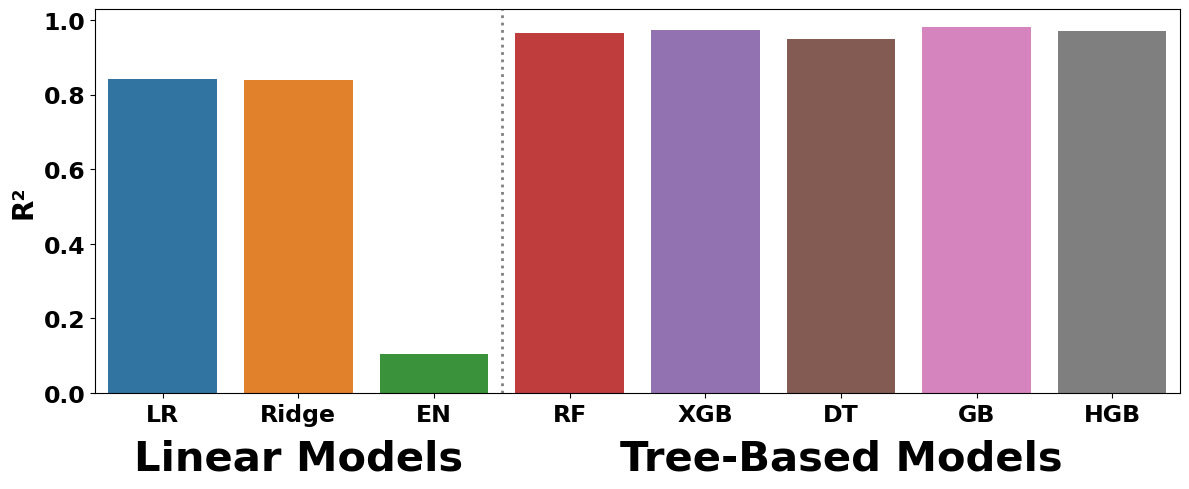

In [103]:
# === Step 3-5: Visualize Regression Performance (Filtered) ===
filtered_df = reg_df[reg_df["R2"] >= 0]

# Define abbreviation mapping
label_map = {
    "LinearRegression": "LR",
    "Ridge": "Ridge",
    "ElasticNet": "EN",
    "RandomForest": "RF",
    "XGBoost": "XGB",
    "DecisionTree": "DT",
    "GradientBoosting": "GB",
    "HistGradientBoosting": "HGB"
}

# Ensure consistent ordering
model_order = filtered_df["Model"].tolist()
abbrev_labels = [label_map.get(model, model) for model in model_order]

plt.figure(figsize=(12, 5))
ax = sns.barplot(x="Model", y="R2", data=filtered_df)

# Apply abbreviated x-axis labels
ax.set_xticklabels(abbrev_labels, rotation=0, ha="center", fontsize=17, fontweight="bold")
plt.yticks(fontsize=17, fontweight="bold")
plt.ylabel("R²", fontsize=20, fontweight="bold")

# Remove default x-axis label
ax.set_xlabel("")

# === Manual group labels positioned below tick labels ===
group_label_y_position = -0.12  # 👈 Adjust this value to move label up/down

if "Ridge" in model_order:
    ridge_idx = model_order.index("Ridge")
    ax.text(ridge_idx, group_label_y_position, "Linear Models", ha='center', va='top',
            fontsize=30, fontweight='bold', transform=ax.get_xaxis_transform())

if "DecisionTree" in model_order:
    dt_idx = model_order.index("DecisionTree")
    ax.text(dt_idx, group_label_y_position, "Tree-Based Models", ha='center', va='top',
            fontsize=30, fontweight='bold', transform=ax.get_xaxis_transform())

# === Add dotted vertical line between EN and RF ===
if "ElasticNet" in model_order and "RandomForest" in model_order:
    en_idx = model_order.index("ElasticNet")
    rf_idx = model_order.index("RandomForest")
    midpoint = (en_idx + rf_idx) / 2
    ax.axvline(x=midpoint, linestyle=':', color='gray', linewidth=2)

plt.tight_layout()
plt.savefig("Step3-5_Regression_Metrics_R2_filtered_grouped_labels_updated_v2.png", dpi=300)
plt.show()

# ============ CLASSIFICATION MODEL ================

In [52]:
# === Step 4: Classification ===
class_target = "Flowering Success"
#class_features = df_train.drop(columns=["phe_ID", "FilledGrain#", class_target])
class_features = df_train.drop(columns=["phe_ID", class_target])
X_cls = StandardScaler().fit_transform(class_features)
y_cls = df_train[class_target]
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(X_cls, y_cls, test_size=0.2, random_state=42)

In [53]:
class_models = {
    "LogisticRegression": LogisticRegression(max_iter=500),
    "RandomForest": RandomForestClassifier(),
    "SVC": SVC(probability=True, kernel='rbf'),
    "XGBoost": XGBClassifier(use_label_encoder=False, eval_metric="logloss"),
    "NeuralNet": MLPClassifier(max_iter=500),
    "DecisionTree": DecisionTreeClassifier(),
    "NaiveBayes": GaussianNB(var_smoothing=1e-9)
}

/Users/minjukim/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


In [54]:
# === Step 4-3(v2): Evaluate Multiple Metrics ===
class_results = {"Model": [], "Accuracy": [], "F1": [], "ROC_AUC": []}
for name, model in class_models.items():
    model.fit(X_train_c, y_train_c)
    preds = model.predict(X_test_c)
    probs = model.predict_proba(X_test_c)[:, 1]
    class_results["Model"].append(name)
    class_results["Accuracy"].append(accuracy_score(y_test_c, preds))
    class_results["F1"].append(f1_score(y_test_c, preds))
    class_results["ROC_AUC"].append(roc_auc_score(y_test_c, probs))

class_df = pd.DataFrame(class_results)
class_df.to_csv("Classification_Performance.csv", index=False)
print("\n=== Classification Performance ===")
print(class_df)

/Users/minjukim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



=== Classification Performance ===
                Model  Accuracy        F1   ROC_AUC
0  LogisticRegression  0.977778  0.983498  0.998667
1        RandomForest  0.942222  0.957655  0.980978
2                 SVC  0.724444  0.810976  0.824889
3             XGBoost  1.000000  1.000000  1.000000
4           NeuralNet  0.848889  0.886667  0.908356
5        DecisionTree  1.000000  1.000000  1.000000
6          NaiveBayes  0.920000  0.943038  0.882889


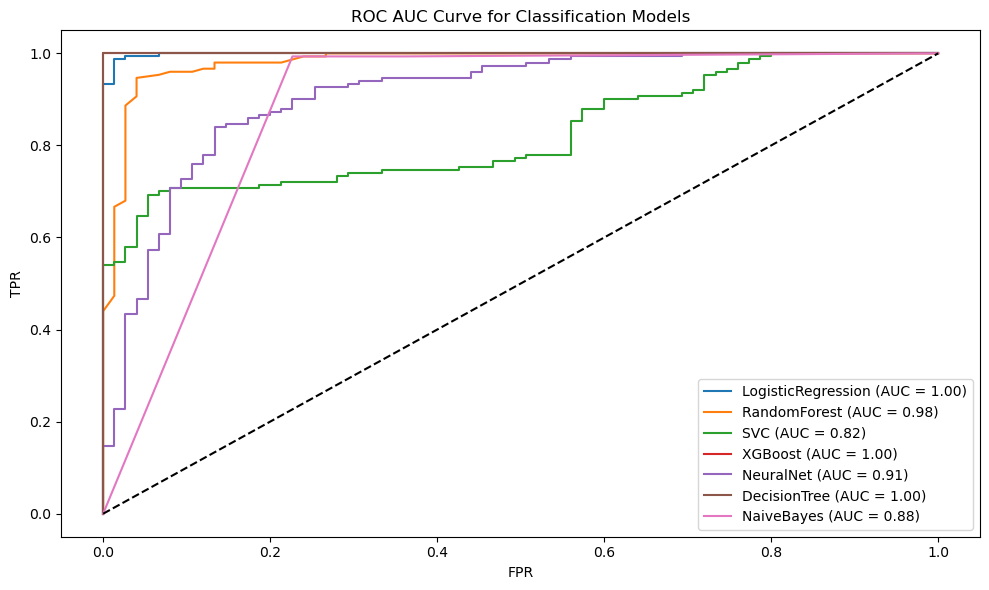

In [55]:
# === Step 4-3A: ROC AUC Curves ===
plt.figure(figsize=(10, 6))
for name, model in class_models.items():
    y_score = model.predict_proba(X_test_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_c, y_score)
    auc = roc_auc_score(y_test_c, y_score)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC AUC Curve for Classification Models")
plt.legend()
plt.tight_layout()
plt.savefig("Step4-3A_ROC_AUC_Comparison.png")
plt.show()

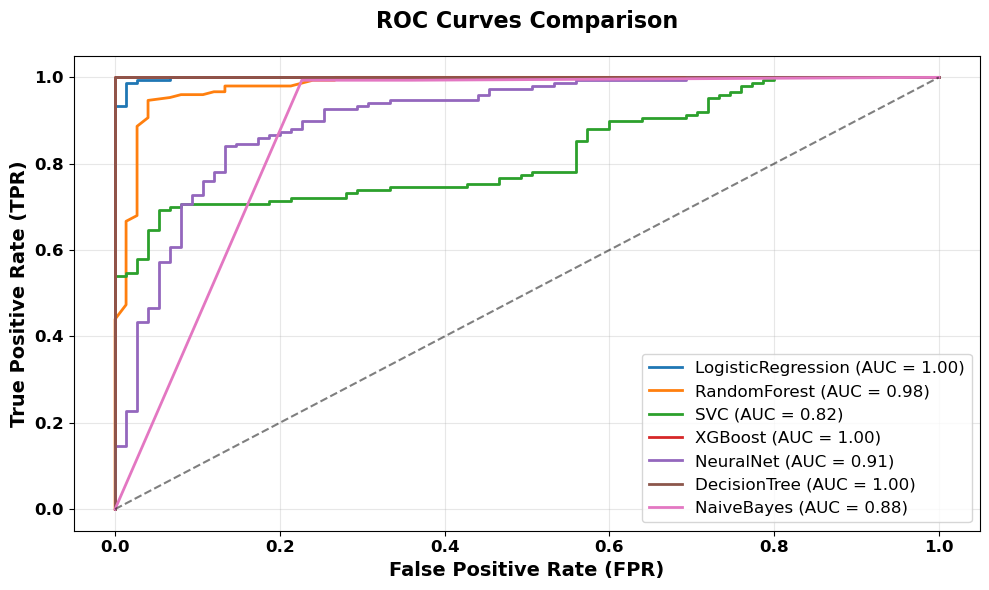

In [56]:
# === Step 4-3A: ROC AUC Curves (Enhanced Styling) ===
plt.figure(figsize=(10, 6))

# Set global font properties
label_font = {
    'family': 'sans-serif',
    'weight': 'bold',
    'size': 14
}

tick_font = {
    'family': 'sans-serif',
    'weight': 'bold',
    'size': 12
}

for name, model in class_models.items():
    y_score = model.predict_proba(X_test_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_c, y_score)
    auc = roc_auc_score(y_test_c, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate (FPR)", fontdict=label_font)
plt.ylabel("True Positive Rate (TPR)", fontdict=label_font)

# Customize tick labels
plt.xticks(fontsize=12, weight='bold')
plt.yticks(fontsize=12, weight='bold')

plt.title("ROC Curves Comparison", fontsize=16, weight='bold', pad=20)
plt.legend(loc="lower right", prop={'size': 12, 'weight': 'normal'})

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Step4-3A_ROC_AUC_Comparison_enhanced.png", dpi=300, bbox_inches='tight')
plt.show()

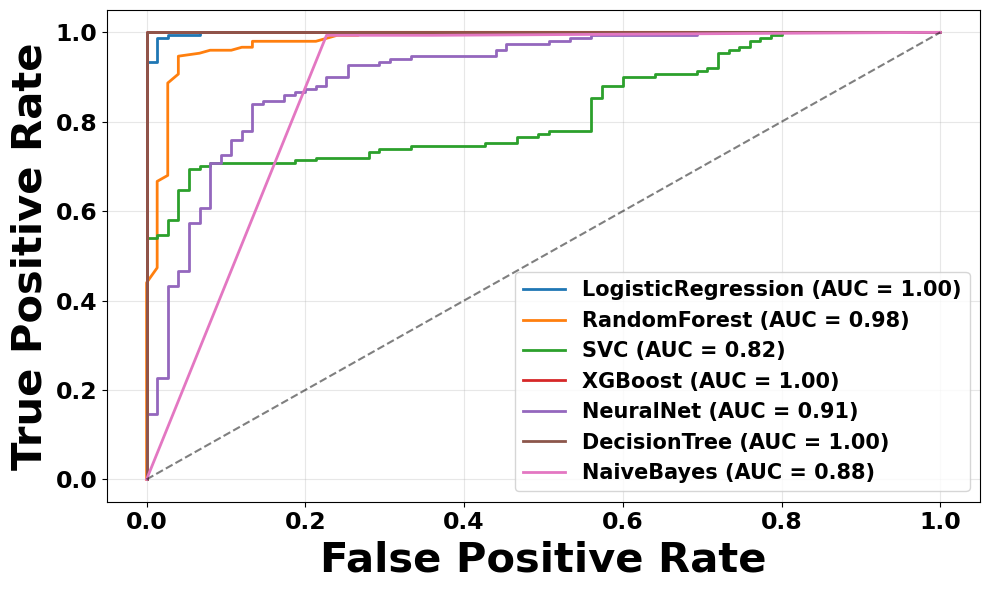

In [105]:
# === Step 4-3A: ROC AUC Curves (Enhanced Styling)(better_labels) ===
plt.figure(figsize=(10, 6))

# Set global font properties
label_font = {
    'family': 'sans-serif',
    'weight': 'bold',
    'size': 30
}

tick_font = {
    'family': 'sans-serif',
    'weight': 'bold',
    'size': 30
}

for name, model in class_models.items():
    y_score = model.predict_proba(X_test_c)[:, 1]
    fpr, tpr, _ = roc_curve(y_test_c, y_score)
    auc = roc_auc_score(y_test_c, y_score)
    plt.plot(fpr, tpr, linewidth=2, label=f"{name} (AUC = {auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
plt.xlabel("False Positive Rate", fontdict=label_font)
plt.ylabel("True Positive Rate", fontdict=label_font)

# Customize tick labels
plt.xticks(fontsize=17, weight='bold')
plt.yticks(fontsize=17, weight='bold')

# === Removed title ===
# plt.title("ROC Curves Comparison", fontsize=16, weight='bold', pad=20)

# Updated legend style
plt.legend(loc="lower right", prop={'size': 15, 'weight': 'bold'})

# Add grid for better readability
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig("Step4-3A_ROC_AUC_Comparison_enhanced_better_label_v2.png", dpi=300, bbox_inches='tight')
plt.show()

In [80]:
# === Step 4-3B: Precision-Recall Curve ===
plt.figure(figsize=(10, 6))
for name, model in class_models.items():
    probs = model.predict_proba(X_test_c)[:, 1]
    precision, recall, _ = precision_recall_curve(y_test_c, probs)
    ap = average_precision_score(y_test_c, probs)
    plt.plot(recall, precision, label=f"{name} (AP = {ap:.2f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve for Classification Models")
plt.legend()
plt.tight_layout()
plt.savefig("Step4-3B_Precision_Recall_Curve.png")
plt.show()

NameError: name 'average_precision_score' is not defined

<Figure size 1000x600 with 0 Axes>

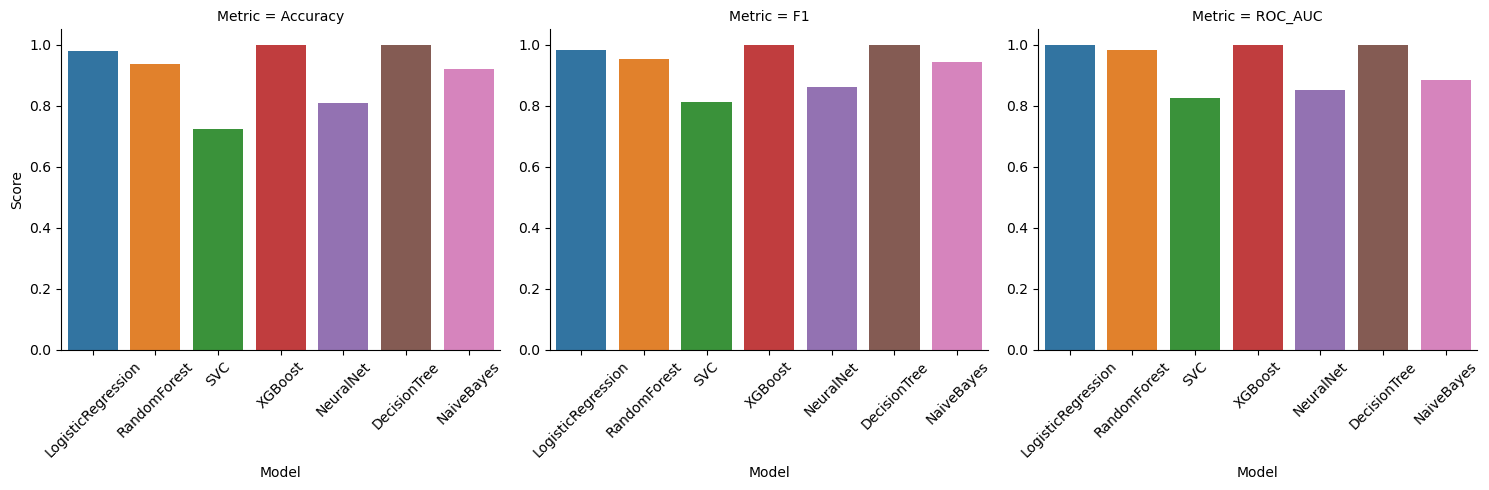

In [23]:
# === Step 4-4: Classification Metric Bar Plot ===
melted = pd.melt(class_df, id_vars=["Model"], var_name="Metric", value_name="Score")
g = sns.catplot(data=melted, kind="bar", x="Model", y="Score", col="Metric", sharey=False)
g.set_xticklabels(rotation=45)
plt.tight_layout()
plt.savefig("Step4-4_Classification_Metrics.png")
plt.show()

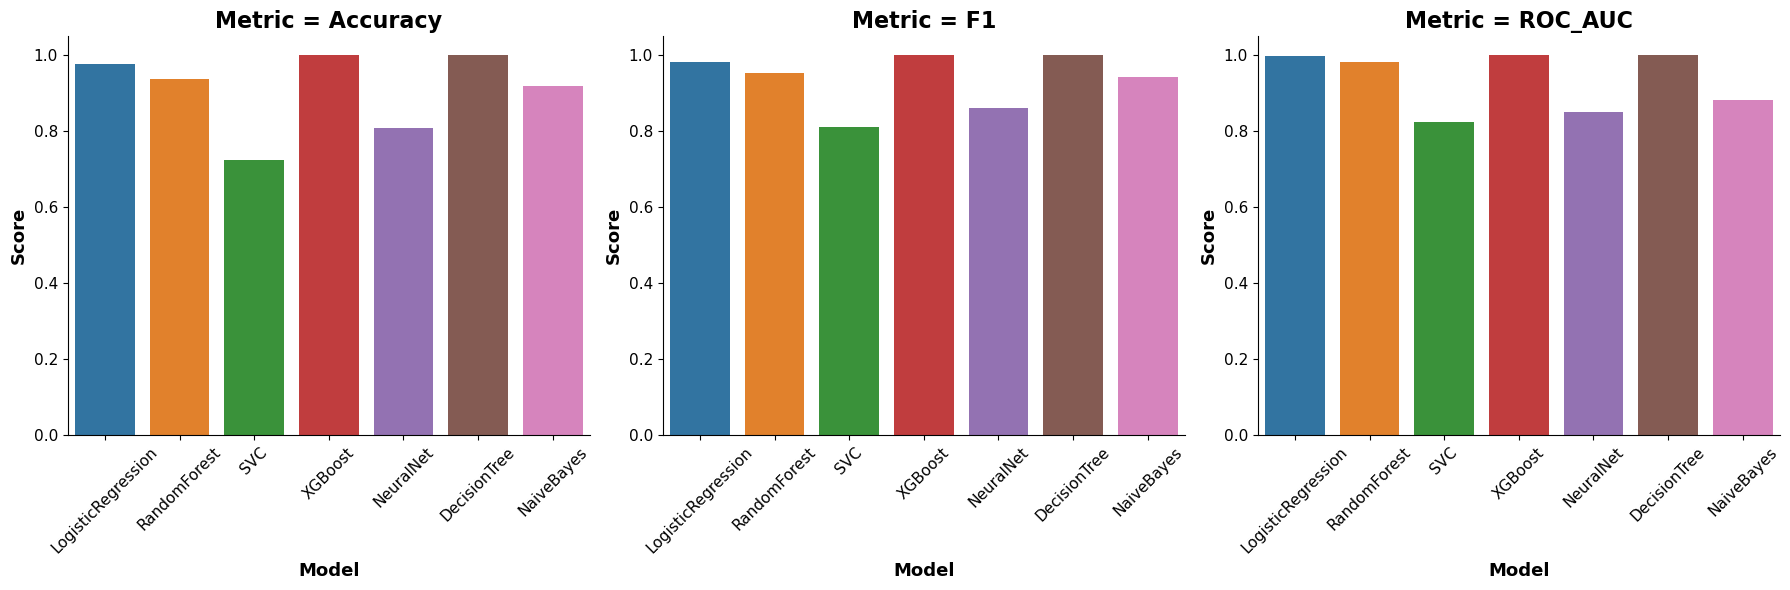

In [24]:
# === Step 4-4: Classification Metric Bar Plot ===
melted = pd.melt(class_df, id_vars=["Model"], var_name="Metric", value_name="Score")
g = sns.catplot(
    data=melted,
    kind="bar",
    x="Model",
    y="Score",
    col="Metric",
    sharey=False,
    height=6,
    aspect=1
)
g.set_xticklabels(rotation=45)

# Customize fonts and titles
for ax in g.axes.flat:
    ax.set_title(ax.get_title(), fontsize=16, fontweight='bold')
    ax.set_xlabel("Model", fontsize=13, fontweight='bold')
    ax.set_ylabel("Score", fontsize=13, fontweight='bold')
    ax.tick_params(axis='y', labelsize=11)
    ax.tick_params(axis='x', labelsize=11)

plt.tight_layout()

# Save each facet as separate PNGs
for i, ax in enumerate(g.axes.flat):
    metric_name = melted["Metric"].unique()[i].replace(" ", "_")
    g.savefig(f"Step4-4_Classification_Metric_{metric_name}.png")

plt.show()

In [45]:
# === Step 5: Best Model Selection ===
best_reg_model_name = reg_df.sort_values(by="R2", ascending=False).iloc[0]["Model"]
best_class_model_name = class_df.sort_values(by="ROC_AUC", ascending=False).iloc[0]["Model"]

print(f"\nBest Regression Model: {best_reg_model_name}")
print(f"Best Classification Model: {best_class_model_name}")


Best Regression Model: GradientBoosting
Best Classification Model: DecisionTree


In [25]:
# === Step 6: Hyperparameter Tuning (only for XGBoost) ===
if best_reg_model_name == "XGBoost":
    param_grid_xgb_reg = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid_xgb_reg = GridSearchCV(
        estimator=XGBRegressor(objective='reg:squarederror', random_state=42),
        param_grid=param_grid_xgb_reg, cv=5, scoring='r2', verbose=1, n_jobs=-1
    )
    grid_xgb_reg.fit(X_train_r, y_train_r)
    best_reg_model = grid_xgb_reg.best_estimator_
    print("✅ Best parameters for regression (XGBoost):", grid_xgb_reg.best_params_)

if best_class_model_name == "XGBoost":
    param_grid_xgb_clf = {
        'n_estimators': [100, 200],
        'max_depth': [3, 6, 10],
        'learning_rate': [0.01, 0.1, 0.3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    grid_xgb_clf = GridSearchCV(
        estimator=XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss"),
        param_grid=param_grid_xgb_clf, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1
    )
    grid_xgb_clf.fit(X_train_c, y_train_c)
    best_class_model = grid_xgb_clf.best_estimator_
    print("✅ Best parameters for classification (XGBoost):", grid_xgb_clf.best_params_)

In [46]:
#Hyperparameter Tuning (only for GradientBoosting)
if best_reg_model_name == "GradientBoosting":
    param_grid_gb_reg = {
        'n_estimators': [100, 200],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.8, 1.0],
        'min_samples_split': [2, 5]
    }
    grid_gb_reg = GridSearchCV(
        estimator=GradientBoostingRegressor(random_state=42),
        param_grid=param_grid_gb_reg, cv=5, scoring='r2', verbose=1, n_jobs=-1
    )
    grid_gb_reg.fit(X_train_r, y_train_r)
    best_reg_model = grid_gb_reg.best_estimator_
    print("✅ Best parameters for regression (GradientBoosting):", grid_gb_reg.best_params_)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


/Users/minjukim/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/minjukim/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/minjukim/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/minjukim/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
/Users/minjukim/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning:

KeyboardInterrupt: 

In [ ]:
#Step 6: Hyperparameter Tuning for Random Forest (Regression)
if best_reg_model_name == "RandomForest":
    param_grid_rf_reg = {
        'n_estimators': [100, 200],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2],
        'max_features': ['auto', 'sqrt']
    }
    grid_rf_reg = GridSearchCV(
        estimator=RandomForestRegressor(random_state=42),
        param_grid=param_grid_rf_reg, cv=5, scoring='r2', verbose=1, n_jobs=-1
    )
    grid_rf_reg.fit(X_train_r, y_train_r)
    best_reg_model = grid_rf_reg.best_estimator_
    print("✅ Best parameters for regression (RandomForest):", grid_rf_reg.best_params_)


In [37]:
# === Step 7: Model Encapsulation for New Dataset Prediction ===
def MJ_XGB_Predictor(new_data_path, train_data_path):
    # === Load Datasets ===
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    # === Encode Categorical Columns ===
    for col in ['Genotype', '3k-population','Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    # === Define Targets & Drop Columns ===
    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    drop_cols = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies','3k-population'
                  'Subpopulation', reg_target, class_target]
    features = [col for col in train_df.columns if col not in drop_cols]

    # === Scale + PCA optional (omitted here as it's Version3-noPCA) ===
    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])
    X_test = scaler.transform(test_df[features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    # === Train XGBoost Models ===
    reg_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train, y_train_reg)
    cls_model.fit(X_train, y_train_cls)

    # === Predict ===
    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test)

    # === Save Output ===
    output_path = new_data_path.replace(".csv", "_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")

In [ ]:
#Step 7: Model Encapsulation using Gradient Boosting Regressor and XGBoost Classifier
def MJ_GB_XGB_Predictor(new_data_path, train_data_path):
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    for col in ['Genotype', '3k-population','Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    drop_cols = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies','3k-population'
                 'Subpopulation', reg_target, class_target]
    features = [col for col in train_df.columns if col not in drop_cols]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])
    X_test = scaler.transform(test_df[features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    reg_model = GradientBoostingRegressor(random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train, y_train_reg)
    cls_model.fit(X_train, y_train_cls)

    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test)

    output_path = new_data_path.replace(".csv", "_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [ ]:
def MJ_RF_XGB_Predictor(new_data_path, train_data_path):
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    for col in ['Genotype', '3k-population','Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    drop_cols = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies','3k-population'
                 'Subpopulation', reg_target, class_target]
    features = [col for col in train_df.columns if col not in drop_cols]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])
    X_test = scaler.transform(test_df[features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    reg_model = RandomForestRegressor(random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train, y_train_reg)
    cls_model.fit(X_train, y_train_cls)

    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test)

    output_path = new_data_path.replace(".csv", "_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [39]:
MJ_XGB_Predictor("1320_combined_phe_Imt_gen_Imt_extval.csv","1320_combined_phe_Imt_gen_Imt_train.csv")

/Users/minjukim/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ Prediction results saved to: 1320_combined_phe_Imt_gen_Imt_extval_prediction.csv


# Step 7: Model Encapsulation using Gradient Boosting Regressor and XGBoost Classifier

In [ ]:
def MJ_GB_XGB_Predictor(new_data_path, train_data_path):
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    for col in ['Genotype', '3k-population','Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    drop_cols = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies','3k-population'
                 'Subpopulation', reg_target, class_target]
    features = [col for col in train_df.columns if col not in drop_cols]

    scaler = StandardScaler()
    X_train = scaler.fit_transform(train_df[features])
    X_test = scaler.transform(test_df[features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    reg_model = GradientBoostingRegressor(random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train, y_train_reg)
    cls_model.fit(X_train, y_train_cls)

    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test)

    output_path = new_data_path.replace(".csv", "_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")

# Step 8: External Validations

In [47]:
# === External Validation: Regression ===
X_ext = df_extval.drop(columns=["phe_ID", "FilledGrain#"])
y_ext_reg = df_extval["FilledGrain#"]
X_ext_scaled = StandardScaler().fit(regression_features).transform(X_ext)

best_reg_model = XGBRegressor(random_state=42)
best_reg_model.fit(X_train_r, y_train_r)
y_pred_ext = best_reg_model.predict(X_ext_scaled)

rmse_ext = mean_squared_error(y_ext_reg, y_pred_ext, squared=False)
mae_ext = mean_absolute_error(y_ext_reg, y_pred_ext)
r2_ext = r2_score(y_ext_reg, y_pred_ext)
print(f"\nExternal Validation - Regression:\nRMSE: {rmse_ext:.3f}, MAE: {mae_ext:.3f}, R²: {r2_ext:.3f}")


External Validation - Regression:
RMSE: 0.101, MAE: 0.064, R²: 0.988


# Gradient Boosting

In [81]:
# === External Validation: Regression ===
X_ext = df_extval.drop(columns=["phe_ID", "FilledGrain#"])
y_ext_reg = df_extval["FilledGrain#"]
X_ext_scaled = StandardScaler().fit(regression_features).transform(X_ext)

best_reg_model = GradientBoostingRegressor(random_state=42)
best_reg_model.fit(X_train_r, y_train_r)
y_pred_ext = best_reg_model.predict(X_ext_scaled)

rmse_ext = mean_squared_error(y_ext_reg, y_pred_ext, squared=False)
mae_ext = mean_absolute_error(y_ext_reg, y_pred_ext)
r2_ext = r2_score(y_ext_reg, y_pred_ext)
print(f"\nExternal Validation - Regression:\nRMSE: {rmse_ext:.3f}, MAE: {mae_ext:.3f}, R²: {r2_ext:.3f}")


External Validation - Regression:
RMSE: 0.124, MAE: 0.081, R²: 0.982


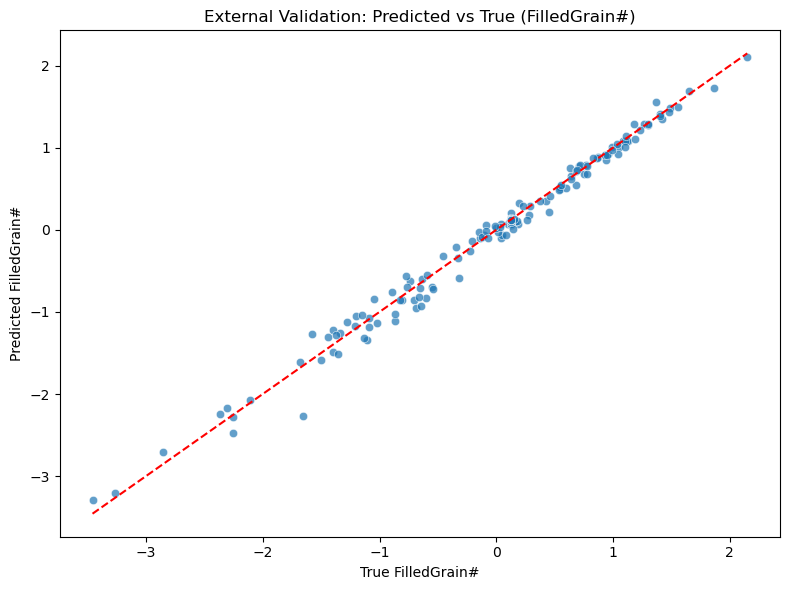

In [48]:
# Plot: Predicted vs True
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_ext_reg, y=y_pred_ext, alpha=0.7)
plt.plot([y_ext_reg.min(), y_ext_reg.max()], [y_ext_reg.min(), y_ext_reg.max()], 'r--')
plt.xlabel("True FilledGrain#")
plt.ylabel("Predicted FilledGrain#")
plt.title("External Validation: Predicted vs True (FilledGrain#)")
plt.tight_layout()
plt.savefig("External_Predicted_vs_True.png")
plt.show()

# Gradient Boosting (Newly Selected Best-fit Model)

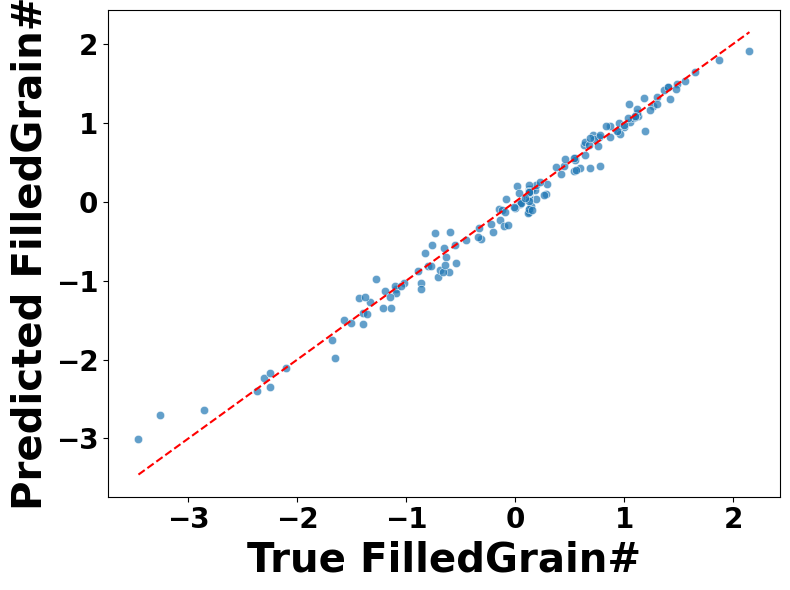

In [109]:
# Plot: Predicted vs True
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_ext_reg, y=y_pred_ext, alpha=0.7)
plt.plot([y_ext_reg.min(), y_ext_reg.max()], [y_ext_reg.min(), y_ext_reg.max()], 'r--')
plt.xlabel("True FilledGrain#", fontsize=29, fontweight="bold")
plt.ylabel("Predicted FilledGrain#", fontsize=29, fontweight="bold")
plt.xticks(fontsize=20, fontweight="bold")
plt.yticks(fontsize=20, fontweight="bold")
# plt.title("External Validation: Predicted vs True (FilledGrain#)")  # Title removed
plt.tight_layout()
plt.savefig("External_Predicted_vs_True_better_label_v2.png")
plt.show()

/Users/minjukim/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


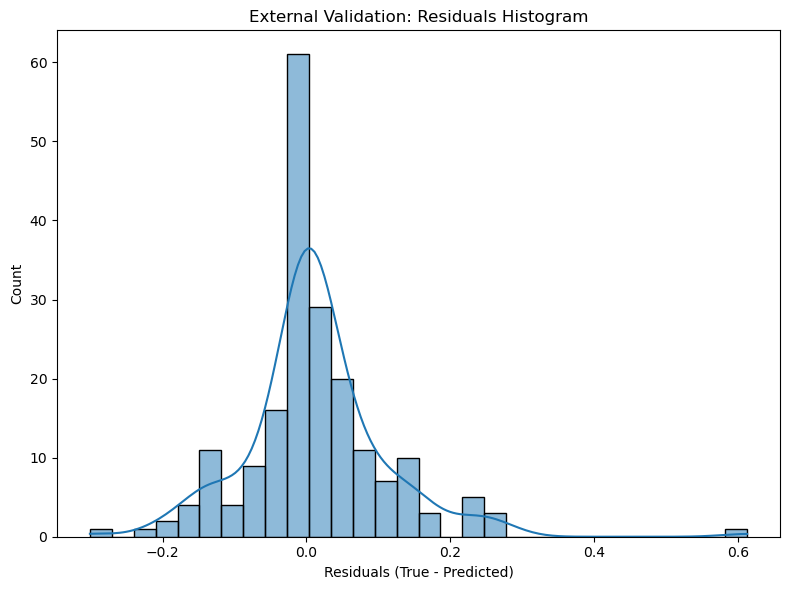

In [49]:
# Plot: Residuals
residuals = y_ext_reg - y_pred_ext
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals (True - Predicted)")
plt.title("External Validation: Residuals Histogram")
plt.tight_layout()
plt.savefig("External_Residuals_Histogram.png")
plt.show()

/Users/minjukim/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


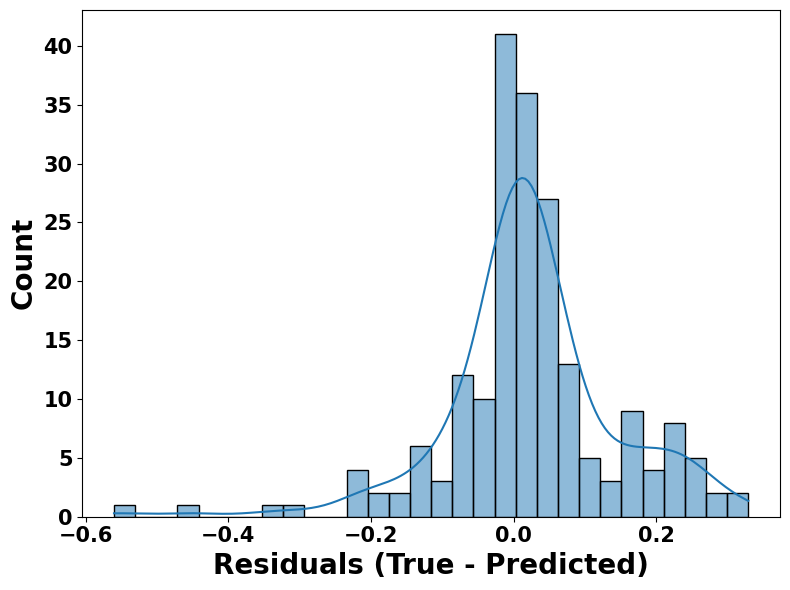

In [85]:
# Plot: Residuals (GradientBoosting)
residuals = y_ext_reg - y_pred_ext
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=30, kde=True)
plt.xlabel("Residuals (True - Predicted)", fontsize=20, fontweight="bold")
plt.ylabel("Count", fontsize=20, fontweight="bold")
plt.xticks(fontsize=15, fontweight="bold")
plt.yticks(fontsize=15, fontweight="bold")
# plt.title("External Validation: Residuals Histogram")  # Title removed
plt.tight_layout()
plt.savefig("External_Residuals_Histogram.png")
plt.show()

In [59]:
# === External Validation: Classification ===
class_features = df_train.drop(columns=["phe_ID", "FilledGrain#"])
X_cls_scaled = StandardScaler().fit(class_features).transform(class_features)
X_ext_cls_scaled = StandardScaler().fit(class_features).transform(X_ext)
y_train_cls = df_train["Flowering Success"]
y_ext_cls = df_extval["Flowering Success"]

In [60]:
best_cls_model = XGBClassifier(random_state=42, use_label_encoder=False, eval_metric="logloss")
best_cls_model.fit(X_cls_scaled, y_train_cls)
y_pred_cls = best_cls_model.predict(X_ext_cls_scaled)
y_prob_cls = best_cls_model.predict_proba(X_ext_cls_scaled)[:, 1]

acc = accuracy_score(y_ext_cls, y_pred_cls)
f1 = f1_score(y_ext_cls, y_pred_cls)
precision = precision_score(y_ext_cls, y_pred_cls)
recall = recall_score(y_ext_cls, y_pred_cls)
roc_auc = roc_auc_score(y_ext_cls, y_prob_cls)
print(f"\nExternal Validation - Classification:\nAccuracy: {acc:.2f}, F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, ROC AUC: {roc_auc:.2f}")

/Users/minjukim/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")



External Validation - Classification:
Accuracy: 1.00, F1: 1.00, Precision: 1.00, Recall: 1.00, ROC AUC: 1.00


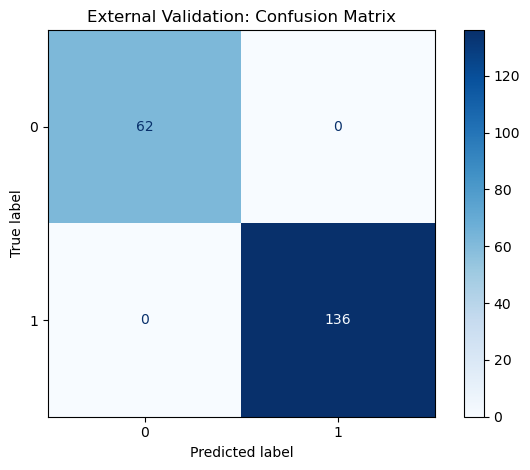

In [61]:
# Confusion Matrix
cm = confusion_matrix(y_ext_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("External Validation: Confusion Matrix")
plt.tight_layout()
plt.savefig("External_Confusion_Matrix.png")
plt.show()

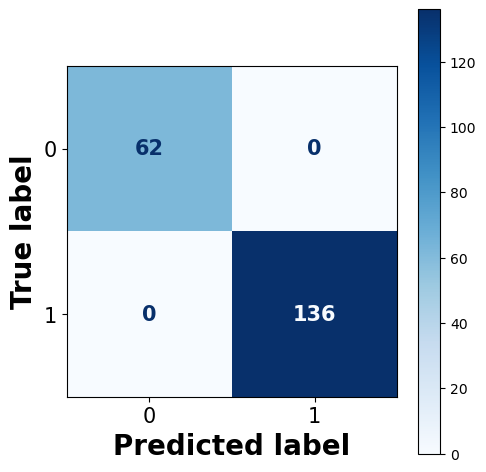

In [87]:
# Confusion Matrix
cm = confusion_matrix(y_ext_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format='d')

# Adjust font sizes for axis and tick labels
ax.set_title("")  # Remove title
ax.set_xlabel("Predicted label", fontsize=20, fontweight='bold')
ax.set_ylabel("True label", fontsize=20, fontweight='bold')
ax.tick_params(axis='x', labelsize=15, width=0.8, labelrotation=0)
ax.tick_params(axis='y', labelsize=15, width=0.8)

# Make confusion matrix numbers bold and larger
for text in disp.text_.ravel():
    text.set_fontsize(15)
    text.set_fontweight('bold')

plt.tight_layout()
plt.savefig("External_Confusion_Matrix.png", dpi=300)
plt.show()

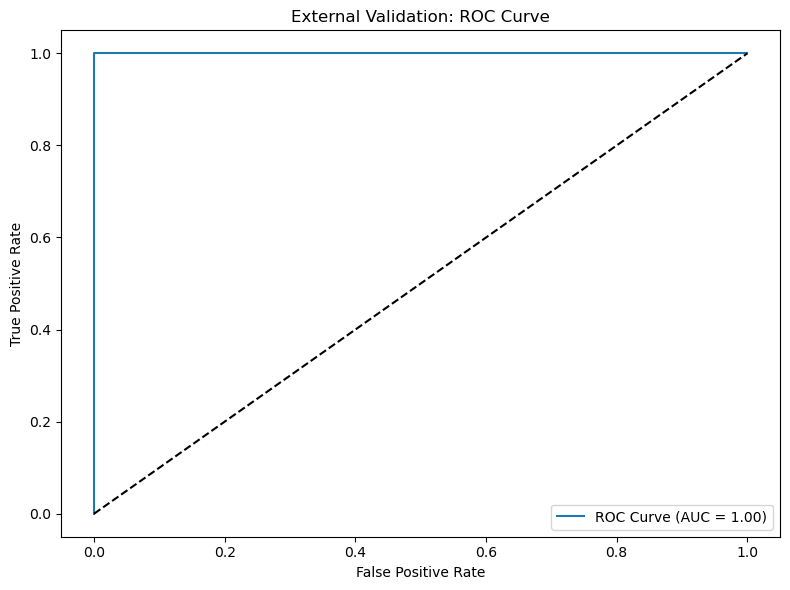

In [62]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_ext_cls, y_prob_cls)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("External Validation: ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("External_ROC_Curve.png")
plt.show()

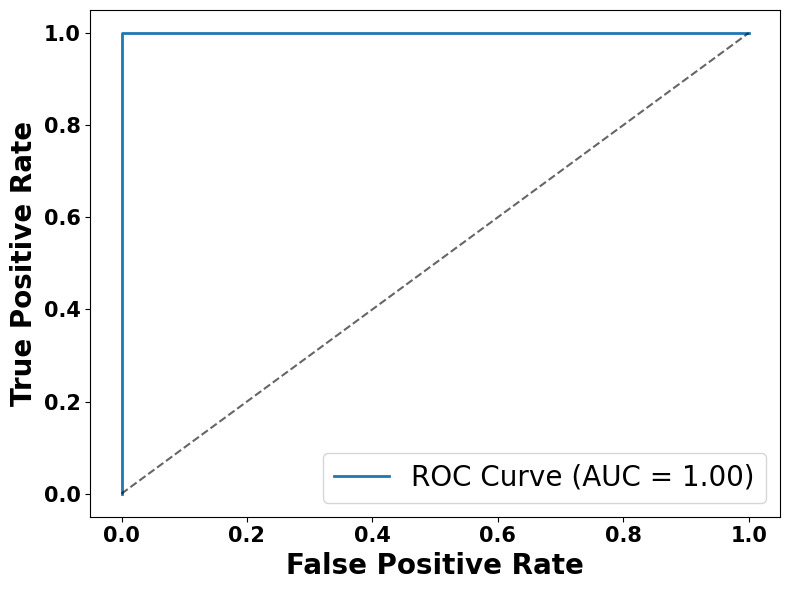

In [88]:
# ROC Curve (better_labeling)
fpr, tpr, _ = roc_curve(y_ext_cls, y_prob_cls)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})", linewidth=2)
plt.plot([0, 1], [0, 1], 'k--', alpha=0.6)
plt.xlabel("False Positive Rate", fontsize=20, fontweight='bold')
plt.ylabel("True Positive Rate", fontsize=20, fontweight='bold')
plt.xticks(fontsize=15, fontweight='bold')
plt.yticks(fontsize=15, fontweight='bold')
# plt.title("External Validation: ROC Curve")  # Removed as requested
plt.legend(fontsize=20, loc="lower right")
plt.tight_layout()
plt.savefig("External_ROC_Curve_better_label.png", dpi=300)
plt.show()

# RandomForest Classifier


External Validation - Classification:
Accuracy: 0.95, F1: 0.97, Precision: 0.96, Recall: 0.97, ROC AUC: 0.99


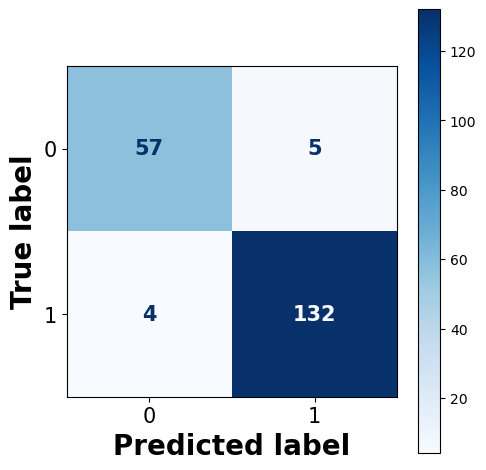

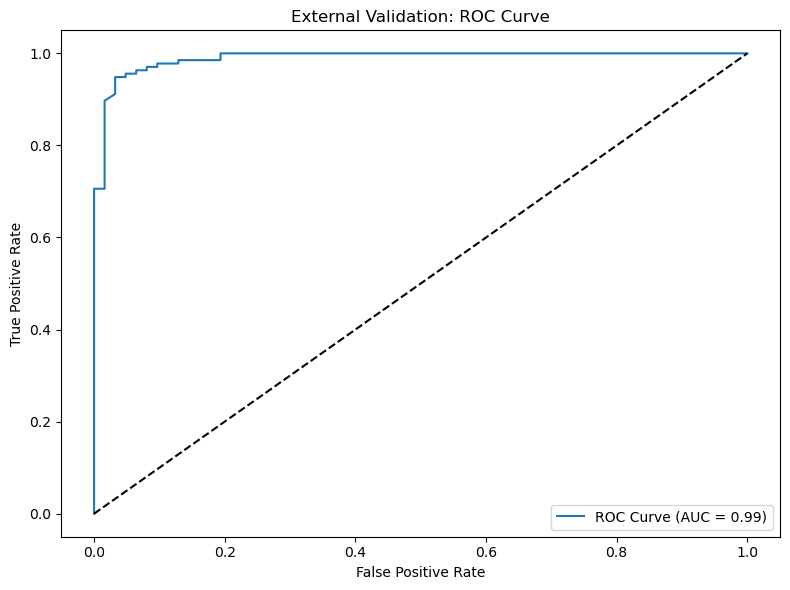

In [110]:
# === External Validation: Classification ===
class_features = df_train.drop(columns=["phe_ID", "FilledGrain#"])
X_cls_scaled = StandardScaler().fit(class_features).transform(class_features)
X_ext_cls_scaled = StandardScaler().fit(class_features).transform(X_ext)
y_train_cls = df_train["Flowering Success"]
y_ext_cls = df_extval["Flowering Success"]

#from sklearn.ensemble import RandomForestClassifier

best_cls_model = RandomForestClassifier(random_state=42)
best_cls_model.fit(X_cls_scaled, y_train_cls)
y_pred_cls = best_cls_model.predict(X_ext_cls_scaled)
y_prob_cls = best_cls_model.predict_proba(X_ext_cls_scaled)[:, 1]

acc = accuracy_score(y_ext_cls, y_pred_cls)
f1 = f1_score(y_ext_cls, y_pred_cls)
precision = precision_score(y_ext_cls, y_pred_cls)
recall = recall_score(y_ext_cls, y_pred_cls)
roc_auc = roc_auc_score(y_ext_cls, y_prob_cls)
print(f"\nExternal Validation - Classification:\nAccuracy: {acc:.2f}, F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, ROC AUC: {roc_auc:.2f}")


# Confusion Matrix
cm = confusion_matrix(y_ext_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format='d')

# Adjust font sizes for axis and tick labels
ax.set_title("")  # Remove title
ax.set_xlabel("Predicted label", fontsize=20, fontweight='bold')
ax.set_ylabel("True label", fontsize=20, fontweight='bold')
ax.tick_params(axis='x', labelsize=15, width=0.8, labelrotation=0)
ax.tick_params(axis='y', labelsize=15, width=0.8)

# Make confusion matrix numbers bold and larger
for text in disp.text_.ravel():
    text.set_fontsize(15)
    text.set_fontweight('bold')

plt.tight_layout()
plt.savefig("External_Confusion_MatrixRF.png", dpi=300)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_ext_cls, y_prob_cls)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("External Validation: ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("External_ROC_Curve_RF.png")
plt.show()


# Logistic Regression Model

/Users/minjukim/anaconda3/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



External Validation - Classification:
Accuracy: 0.99, F1: 0.99, Precision: 0.99, Recall: 1.00, ROC AUC: 1.00


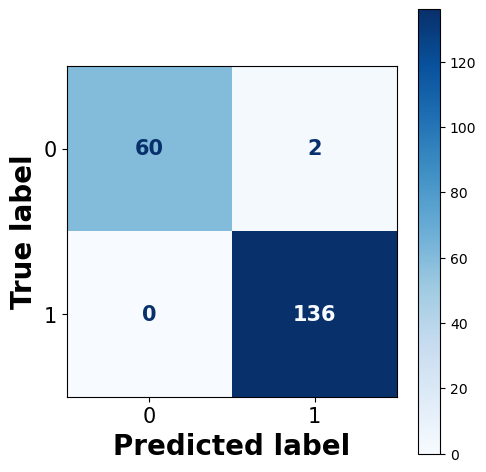

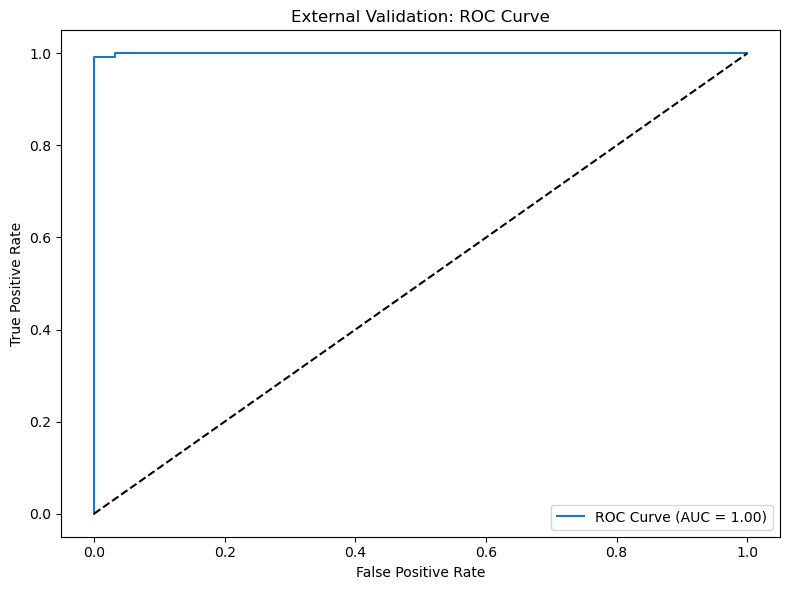

In [111]:
# === External Validation: Classification ===
class_features = df_train.drop(columns=["phe_ID", "FilledGrain#"])
X_cls_scaled = StandardScaler().fit(class_features).transform(class_features)
X_ext_cls_scaled = StandardScaler().fit(class_features).transform(X_ext)
y_train_cls = df_train["Flowering Success"]
y_ext_cls = df_extval["Flowering Success"]

#from sklearn.ensemble import RandomForestClassifier

best_cls_model = LogisticRegression(max_iter=500)
best_cls_model.fit(X_cls_scaled, y_train_cls)
y_pred_cls = best_cls_model.predict(X_ext_cls_scaled)
y_prob_cls = best_cls_model.predict_proba(X_ext_cls_scaled)[:, 1]

acc = accuracy_score(y_ext_cls, y_pred_cls)
f1 = f1_score(y_ext_cls, y_pred_cls)
precision = precision_score(y_ext_cls, y_pred_cls)
recall = recall_score(y_ext_cls, y_pred_cls)
roc_auc = roc_auc_score(y_ext_cls, y_prob_cls)
print(f"\nExternal Validation - Classification:\nAccuracy: {acc:.2f}, F1: {f1:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, ROC AUC: {roc_auc:.2f}")


# Confusion Matrix
cm = confusion_matrix(y_ext_cls, y_pred_cls)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(5, 5))
disp.plot(ax=ax, cmap="Blues", values_format='d')

# Adjust font sizes for axis and tick labels
ax.set_title("")  # Remove title
ax.set_xlabel("Predicted label", fontsize=20, fontweight='bold')
ax.set_ylabel("True label", fontsize=20, fontweight='bold')
ax.tick_params(axis='x', labelsize=15, width=0.8, labelrotation=0)
ax.tick_params(axis='y', labelsize=15, width=0.8)

# Make confusion matrix numbers bold and larger
for text in disp.text_.ravel():
    text.set_fontsize(15)
    text.set_fontweight('bold')

plt.tight_layout()
plt.savefig("External_Confusion_Matrix_LR.png", dpi=300)
plt.show()

# ROC Curve
fpr, tpr, _ = roc_curve(y_ext_cls, y_prob_cls)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("External Validation: ROC Curve")
plt.legend()
plt.tight_layout()
plt.savefig("External_ROC_Curve_LR.png")
plt.show()

In [ ]:
def MJ_RF_XGB_Predictor(new_data_path, train_data_path):
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    for col in ['Genotype', '3k-population', 'Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    reg_target = "FilledGrain#"
    class_target = "Flowering Success"

    base_drop = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID',
                 'Subspecies', '3k-population', 'Subpopulation']

    # Separate feature lists for regression and classification
    drop_cols_reg = base_drop + [reg_target]  # drop reg_target, keep class_target
    drop_cols_cls = base_drop + [class_target]  # drop class_target, keep reg_target

    reg_features = [col for col in train_df.columns if col not in drop_cols_reg]
    cls_features = [col for col in train_df.columns if col not in drop_cols_cls]

    # === Scaling
    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(train_df[reg_features])
    X_test_reg = scaler_reg.transform(test_df[reg_features])

    scaler_cls = StandardScaler()
    X_train_cls = scaler_cls.fit_transform(train_df[cls_features])
    X_test_cls = scaler_cls.transform(test_df[cls_features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    # === Model training
    reg_model = RandomForestRegressor(random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train_reg, y_train_reg)
    cls_model.fit(X_train_cls, y_train_cls)

    # === Prediction
    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test_reg)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test_cls)

    # === Save
    output_path = new_data_path.replace(".csv", "_RF_XGB_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [ ]:
def MJ_GB_XGB_Predictor(new_data_path, train_data_path):
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    for col in ['Genotype', '3k-population', 'Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    reg_target = "FilledGrain#"
    class_target = "Flowering Success"

    base_drop = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', '3k-population', 'Subpopulation']

    # Drop logic per model
    drop_cols_reg = base_drop + [reg_target]  # drop regression target
    drop_cols_cls = base_drop + [class_target]  # drop classification target

    reg_features = [col for col in train_df.columns if col not in drop_cols_reg]
    cls_features = [col for col in train_df.columns if col not in drop_cols_cls]

    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(train_df[reg_features])
    X_test_reg = scaler_reg.transform(test_df[reg_features])

    scaler_cls = StandardScaler()
    X_train_cls = scaler_cls.fit_transform(train_df[cls_features])
    X_test_cls = scaler_cls.transform(test_df[cls_features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    reg_model = GradientBoostingRegressor(random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train_reg, y_train_reg)
    cls_model.fit(X_train_cls, y_train_cls)

    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test_reg)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test_cls)

    output_path = new_data_path.replace(".csv", "_GB_XGB_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [ ]:
def MJ_XGB_Predictor(new_data_path, train_data_path):
    # === Load Datasets ===
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    # === Encode Categorical Columns ===
    for col in ['Genotype', '3k-population', 'Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    # === Define Targets & Feature Lists ===
    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    base_drop = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', '3k-population', 'Subpopulation']

    drop_cols_reg = base_drop + [reg_target]
    drop_cols_cls = base_drop + [class_target]

    reg_features = [col for col in train_df.columns if col not in drop_cols_reg]
    cls_features = [col for col in train_df.columns if col not in drop_cols_cls]

    # === Scale ===
    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(train_df[reg_features])
    X_test_reg = scaler_reg.transform(test_df[reg_features])

    scaler_cls = StandardScaler()
    X_train_cls = scaler_cls.fit_transform(train_df[cls_features])
    X_test_cls = scaler_cls.transform(test_df[cls_features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    # === Train XGBoost Models ===
    reg_model = XGBRegressor(objective='reg:squarederror', random_state=42)
    cls_model = XGBClassifier(objective='binary:logistic', random_state=42, use_label_encoder=False, eval_metric="logloss")

    reg_model.fit(X_train_reg, y_train_reg)
    cls_model.fit(X_train_cls, y_train_cls)

    # === Predict ===
    test_df['Predicted_FilledGrain#'] = reg_model.predict(X_test_reg)
    test_df['Predicted_Flowering_Success'] = cls_model.predict(X_test_cls)

    # === Save Output ===
    output_path = new_data_path.replace(".csv", "_XGB_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [ ]:
#Multi-model 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd

def MJ_MultiModel_Predictor(new_data_path, train_data_path):
    # === Load Datasets ===
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    # === Encode Categorical Columns ===
    for col in ['Genotype', '3k-population', 'Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    # === Define Targets & Feature Lists ===
    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    base_drop = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', '3k-population', 'Subpopulation']

    drop_cols_reg = base_drop + [reg_target]
    drop_cols_cls = base_drop + [class_target]

    reg_features = [col for col in train_df.columns if col not in drop_cols_reg]
    cls_features = [col for col in train_df.columns if col not in drop_cols_cls]

    # === Scale ===
    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(train_df[reg_features])
    X_test_reg = scaler_reg.transform(test_df[reg_features])

    scaler_cls = StandardScaler()
    X_train_cls = scaler_cls.fit_transform(train_df[cls_features])
    X_test_cls = scaler_cls.transform(test_df[cls_features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    # === Regression Models ===
    reg_models = {
        "RF": RandomForestRegressor(random_state=42),
        "GB": GradientBoostingRegressor(random_state=42),
        "XGB": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    for name, model in reg_models.items():
        model.fit(X_train_reg, y_train_reg)
        test_df[f'Predicted_{reg_target}_{name}'] = model.predict(X_test_reg)

    # === Classification Models ===
    cls_models = {
        "DT": DecisionTreeClassifier(random_state=42),
        "XGB": XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric="logloss", random_state=42)
    }

    for name, model in cls_models.items():
        model.fit(X_train_cls, y_train_cls)
        test_df[f'Predicted_{class_target}_{name}'] = model.predict(X_test_cls)

    # === Save Output ===
    output_path = new_data_path.replace(".csv", "_multiModel_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")

# All_in_one_function

In [63]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBRegressor, XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

def MJ_MultiModel_Predictor(new_data_path, train_data_path):
    # === Load Datasets ===
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    # === Encode Categorical Columns ===
    for col in ['Genotype', '3k-population', 'Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    # === Define Targets & Feature Lists ===
    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    base_drop = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', '3k-population', 'Subpopulation']

    drop_cols_reg = base_drop + [reg_target]
    drop_cols_cls = base_drop + [class_target]

    reg_features = [col for col in train_df.columns if col not in drop_cols_reg]
    cls_features = [col for col in train_df.columns if col not in drop_cols_cls]

    # === Scale ===
    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(train_df[reg_features])
    X_test_reg = scaler_reg.transform(test_df[reg_features])

    scaler_cls = StandardScaler()
    X_train_cls = scaler_cls.fit_transform(train_df[cls_features])
    X_test_cls = scaler_cls.transform(test_df[cls_features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    # === Stats for Inverse Transform (assumes log1p+zscore on FilledGrain#)
    y_mean = y_train_reg.mean()
    y_std = y_train_reg.std()

    def inverse_z_log1p(arr):
        return np.expm1(arr * y_std + y_mean)

    # === Regression Models ===
    reg_models = {
        "RF": RandomForestRegressor(random_state=42),
        "GB": GradientBoostingRegressor(random_state=42),
        "XGB": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    for name, model in reg_models.items():
        model.fit(X_train_reg, y_train_reg)
        y_pred_train = model.predict(X_train_reg)
        y_true_orig = inverse_z_log1p(y_train_reg)
        y_pred_orig = inverse_z_log1p(y_pred_train)
        test_df[f'Predicted_{reg_target}_{name}'] = model.predict(X_test_reg)

        # Plot Predicted vs True
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_true_orig, y=y_pred_orig, alpha=0.5)
        sns.regplot(x=y_true_orig, y=y_pred_orig, scatter=False, color='red', ci=None)
        plt.xlabel("True FilledGrain#", fontsize=12, fontweight="bold")
        plt.ylabel(f"Predicted FilledGrain# ({name})", fontsize=12, fontweight="bold")
        plt.title(f"Predicted vs True – {name}", fontsize=14, fontweight="bold")
        plt.xticks(fontsize=10, fontweight="bold")
        plt.yticks(fontsize=10, fontweight="bold")
        plt.tight_layout()
        plt.savefig(f"scatter_FilledGrain_Pred_vs_True_{name}.png")
        plt.close()

    # === Classification Models ===
    cls_models = {
        "DT": DecisionTreeClassifier(random_state=42),
        "XGB": XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric="logloss", random_state=42)
    }

    for name, model in cls_models.items():
        model.fit(X_train_cls, y_train_cls)
        test_df[f'Predicted_{class_target}_{name}'] = model.predict(X_test_cls)

        # Plot Confusion Matrix
        y_pred_cls = model.predict(X_train_cls)
        cm = confusion_matrix(y_train_cls, y_pred_cls)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        fig, ax = plt.subplots(figsize=(4.5, 4.5))
        disp.plot(ax=ax, cmap="Blues", values_format='d')
        plt.title(f"Confusion Matrix – {name}", fontsize=14, fontweight='bold')
        plt.xlabel("Predicted", fontsize=11, fontweight='bold')
        plt.ylabel("True", fontsize=11, fontweight='bold')
        plt.xticks(fontsize=10, fontweight='bold')
        plt.yticks(fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_{name}.png")
        plt.close()

    # === Save Output ===
    output_path = new_data_path.replace(".csv", "_multiModel_prediction.csv")
    test_df.to_csv(output_path, index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [68]:
MJ_MultiModel_Predictor("1320_combined_phe_Imt_gen_Imt_extval.csv","1320_combined_phe_Imt_gen_Imt_train.csv")

/Users/minjukim/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ Prediction results saved to: 1320_combined_phe_Imt_gen_Imt_extval_multiModel_prediction.csv


In [69]:
def MJ_MultiModel_Predictor(new_data_path, train_data_path):
    # === Load Datasets ===
    train_df = pd.read_csv(train_data_path)
    test_df = pd.read_csv(new_data_path)

    # === Encode Categorical Columns ===
    for col in ['Genotype', '3k-population', 'Treatment']:
        le = LabelEncoder()
        if col in train_df.columns:
            train_df[col] = le.fit_transform(train_df[col].astype(str))
        if col in test_df.columns:
            test_df[col] = le.transform(test_df[col].astype(str))

    # === Define Targets & Feature Lists ===
    reg_target = "FilledGrain#"
    class_target = "Flowering Success"
    base_drop = ['phe_ID', 'Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', '3k-population', 'Subpopulation']

    drop_cols_reg = base_drop + [reg_target]
    drop_cols_cls = base_drop + [class_target]

    reg_features = [col for col in train_df.columns if col not in drop_cols_reg]
    cls_features = [col for col in train_df.columns if col not in drop_cols_cls]

    # === Scale ===
    scaler_reg = StandardScaler()
    X_train_reg = scaler_reg.fit_transform(train_df[reg_features])
    X_test_reg = scaler_reg.transform(test_df[reg_features])

    scaler_cls = StandardScaler()
    X_train_cls = scaler_cls.fit_transform(train_df[cls_features])
    X_test_cls = scaler_cls.transform(test_df[cls_features])

    y_train_reg = train_df[reg_target]
    y_train_cls = train_df[class_target]

    # === Stats for Inverse Transform (assumes log1p+zscore on FilledGrain#)
    y_mean = y_train_reg.mean()
    y_std = y_train_reg.std()

    def inverse_z_log1p(arr):
        return np.expm1(arr * y_std + y_mean)

    reg_metrics = []
    cls_metrics = []

    # === Regression Models ===
    reg_models = {
        "RF": RandomForestRegressor(random_state=42),
        "GB": GradientBoostingRegressor(random_state=42),
        "XGB": XGBRegressor(objective='reg:squarederror', random_state=42)
    }

    for name, model in reg_models.items():
        model.fit(X_train_reg, y_train_reg)
        y_pred_train = model.predict(X_train_reg)
        y_true_orig = inverse_z_log1p(y_train_reg)
        y_pred_orig = inverse_z_log1p(y_pred_train)
        test_df[f'Predicted_{reg_target}_{name}'] = model.predict(X_test_reg)

        # Plot Predicted vs True
        plt.figure(figsize=(6, 6))
        sns.scatterplot(x=y_true_orig, y=y_pred_orig, alpha=0.5)
        sns.regplot(x=y_true_orig, y=y_pred_orig, scatter=False, color='red', ci=None)
        plt.xlabel("True FilledGrain#", fontsize=12, fontweight="bold")
        plt.ylabel(f"Predicted FilledGrain# ({name})", fontsize=12, fontweight="bold")
        plt.title(f"Predicted vs True – {name}", fontsize=14, fontweight="bold")
        plt.xticks(fontsize=10, fontweight="bold")
        plt.yticks(fontsize=10, fontweight="bold")
        plt.tight_layout()
        plt.savefig(f"scatter_FilledGrain_Pred_vs_True_{name}.png")
        plt.close()

        # Collect regression metrics
        reg_metrics.append({
            "Model": name,
            "RMSE": mean_squared_error(y_true_orig, y_pred_orig, squared=False),
            "MAE": mean_absolute_error(y_true_orig, y_pred_orig),
            "R2": r2_score(y_true_orig, y_pred_orig)
        })

    # === Classification Models ===
    cls_models = {
        "DT": DecisionTreeClassifier(random_state=42),
        "XGB": XGBClassifier(objective='binary:logistic', use_label_encoder=False, eval_metric="logloss", random_state=42)
    }

    for name, model in cls_models.items():
        model.fit(X_train_cls, y_train_cls)
        test_df[f'Predicted_{class_target}_{name}'] = model.predict(X_test_cls)

        # Plot Confusion Matrix
        y_pred_cls = model.predict(X_train_cls)
        cm = confusion_matrix(y_train_cls, y_pred_cls)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
        fig, ax = plt.subplots(figsize=(4.5, 4.5))
        disp.plot(ax=ax, cmap="Blues", values_format='d')
        plt.title(f"Confusion Matrix – {name}", fontsize=14, fontweight='bold')
        plt.xlabel("Predicted", fontsize=11, fontweight='bold')
        plt.ylabel("True", fontsize=11, fontweight='bold')
        plt.xticks(fontsize=10, fontweight='bold')
        plt.yticks(fontsize=10, fontweight='bold')
        plt.tight_layout()
        plt.savefig(f"confusion_matrix_{name}_v2.png")
        plt.close()

        # Collect classification metric
        y_pred_proba = model.predict_proba(X_train_cls)[:, 1]
        roc_auc = roc_auc_score(y_train_cls, y_pred_proba)
        cls_metrics.append({
            "Model": name,
            "ROC_AUC": roc_auc
        })

    # === Save Output ===
    output_path = new_data_path.replace(".csv", "_multiModel_prediction_v2.csv")
    test_df.to_csv(output_path, index=False)
    pd.DataFrame(reg_metrics).to_csv("regression_model_performance.csv", index=False)
    pd.DataFrame(cls_metrics).to_csv("classification_model_performance.csv", index=False)
    print(f"✅ Prediction results saved to: {output_path}")


In [70]:
MJ_MultiModel_Predictor("1320_combined_phe_Imt_gen_Imt_extval.csv","1320_combined_phe_Imt_gen_Imt_train.csv")

/Users/minjukim/anaconda3/lib/python3.10/site-packages/xgboost/sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


✅ Prediction results saved to: 1320_combined_phe_Imt_gen_Imt_extval_multiModel_prediction_v2.csv


# Feature Importance Analysis

## Version 1

In [12]:
# === Step 0: Load Data ===
df = pd.read_csv("1320_combined_phe_Imt_gen_Imt.csv")
drop_cols = ['Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', 'Subpopulation', '3k-population']
df.drop(columns=drop_cols, inplace=True)

for col in ['Genotype', 'Treatment']:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

/var/folders/n5/h18rv7ns13l1ty5kvvj2yd440000gn/T/ipykernel_13676/963827531.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("1320_combined_phe_Imt_gen_Imt.csv")


In [13]:
# === 2. Define feature sets ===
# Assume SNP columns start with a digit or match pattern like "1_100"
snp_cols = [col for col in df.columns if "_" in col and col.split("_")[0].isdigit()]
pheno_cols = [col for col in df.columns if col not in snp_cols + ['IRGC', 'phe_ID']]

X = df[snp_cols]
y_class = df["Flowering Success"]
y_reg = df["FilledGrain#"]

In [14]:
# === 3. Train Classifier: Random Forest ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y_class)
importances_clf = clf.feature_importances_
top_clf_idx = np.argsort(importances_clf)[::-1]

In [15]:
# === 4. Train Regressor: XGBoost ===
xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0)
xgb.fit(X, y_reg)
importances_regr = xgb.feature_importances_
top_regr_idx = np.argsort(importances_regr)[::-1]

In [16]:
# === 5. Save Top SNPs ===
pd.DataFrame(X.columns[top_clf_idx[:10]]).to_csv("Top_10_SNPs_Classifier_RF.csv", index=False)
pd.DataFrame(X.columns[top_clf_idx[:30]]).to_csv("Top_30_SNPs_Classifier_RF.csv", index=False)
pd.DataFrame(X.columns[top_regr_idx[:10]]).to_csv("Top_10_SNPs_Regressor_XGB.csv", index=False)
pd.DataFrame(X.columns[top_regr_idx[:30]]).to_csv("Top_30_SNPs_Regressor_XGB.csv", index=False)

In [17]:
# === 6. Save Top Phenotypes (by std dev as proxy for signal) ===
pheno_importance = df[pheno_cols].std().sort_values(ascending=False)
top_pheno = pheno_importance.head(5).index.tolist()
pd.DataFrame(top_pheno).to_csv("Top_5_Phenotypes.csv", index=False)

In [18]:
# === 7. Plot Feature Importances ===
def plot_importance(colnames, importances, indices, title, filename):
    plt.figure(figsize=(8, 6))
    sns.barplot(x=importances[indices[:10]], y=[colnames[i] for i in indices[:10]])
    plt.title(title)
    plt.tight_layout()
    plt.savefig(filename)
    plt.close()

plot_importance(X.columns, importances_clf, top_clf_idx, "Top 10 SNPs (Classifier: RF)", "RF_top10_SNPs.png")
plot_importance(X.columns, importances_regr, top_regr_idx, "Top 10 SNPs (Regressor: XGB)", "XGB_top10_SNPs.png")

/Users/minjukim/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/minjukim/anaconda3/lib/python3.10/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


In [22]:
# === 8. Estimate Epistasis (simple proxy via permutation importance on top SNPs) ===
top10_snp_rf = X.iloc[:, top_clf_idx[:10]]
epi_rf = permutation_importance(clf, top10_snp_rf, y_class, n_repeats=10, random_state=42)

epi_df = pd.DataFrame({
    "SNP": top10_snp_rf.columns,
    "Mean Importance": epi_rf.importances_mean,
    "STD": epi_rf.importances_std
})
epi_df.to_csv("Epistasis_Classifier_RF_Top10.csv", index=False)

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- 1_10015528
- 1_1002503
- 1_10046498
- 1_1006328
- 1_10063893
- ...


In [25]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBRegressor

# === Step 0: Load Data ===
df = pd.read_csv("1320_combined_phe_Imt_gen_Imt.csv")
drop_cols = ['Plot#', 'Entry#', 'Block#', 'Rep#', 'IRGC ID', 'Subspecies', 'Subpopulation', '3k-population']
df.drop(columns=drop_cols, inplace=True)

for col in ['Genotype', 'Treatment']:
    if df[col].dtype == 'object':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])

# === 2. Define feature sets ===
snp_cols = [col for col in df.columns if "_" in col and col.split("_")[0].isdigit()]
X = df[snp_cols]
y_class = df["Flowering Success"]
y_reg = df["FilledGrain#"]

# === 3. Train Classifier and Regressor ===
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X, y_class)
importances_clf = clf.feature_importances_
top30_idx_clf = np.argsort(importances_clf)[::-1][:30]

xgb = XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42, verbosity=0)
xgb.fit(X, y_reg)
importances_regr = xgb.feature_importances_
top30_idx_regr = np.argsort(importances_regr)[::-1][:30]

# === 4. Save Top 30 Features for Classifier ===
top30_clf_df = pd.DataFrame({
    "Feature": X.columns[top30_idx_clf],
    "Importance": importances_clf[top30_idx_clf]
})
top30_clf_df.to_csv("Top30_Features_Classifier_RF.csv", index=False)

# === 5. Save Top 30 Features for Regressor ===
top30_regr_df = pd.DataFrame({
    "Feature": X.columns[top30_idx_regr],
    "Importance": importances_regr[top30_idx_regr]
})
top30_regr_df.to_csv("Top30_Features_Regressor_XGB.csv", index=False)

# === 6. Plot Top 30 Features for Classifier ===
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top30_clf_df, color='skyblue')
plt.title("Top 30 SNPs (Classifier: Random Forest)")
plt.tight_layout()
plt.savefig("Top30_SNPs_Classifier_RF.png", dpi=300)
plt.close()

# === 7. Plot Top 30 Features for Regressor ===
plt.figure(figsize=(10, 8))
sns.barplot(x="Importance", y="Feature", data=top30_regr_df, color='lightgreen')
plt.title("Top 30 SNPs (Regressor: XGBoost)")
plt.tight_layout()
plt.savefig("Top30_SNPs_Regressor_XGB.png", dpi=300)
plt.close()


/var/folders/n5/h18rv7ns13l1ty5kvvj2yd440000gn/T/ipykernel_13676/1564059471.py:9: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("1320_combined_phe_Imt_gen_Imt.csv")


In [ ]:
# Viersion 2

# Caturing Epistasis